In [292]:
%matplotlib notebook
# %autosave 10
# %lsmagic
# print(plt.style.available)

import numpy as np
from pylab import *
from matplotlib import gridspec
from matplotlib import pyplot as plt
import subprocess

In [283]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

#### ========================================================  NOTE: defs
# http://choorucode.com/2014/11/13/how-to-get-orthographic-projection-in-3d-plot-of-matplotlib/ 
def orthogonal_proj(zfront, zback):
    a = (zfront+zback)/(zfront-zback)
    b = -2*(zfront*zback)/(zfront-zback)
    # -0.0001 added for numerical stability as suggested in:
    # http://stackoverflow.com/questions/23840756
    return np.array([[1,0,0,0],
                        [0,1,0,0],
                        [0,0,a,b],
                        [0,0,-0.0001,zback]])
proj3d.persp_transformation = orthogonal_proj # workaround #ax.invert_zaxis() 

In [284]:
def read_poscar(file):
    lattice = []; positions = []; labels = []
    with open(file, mode='r') as f:
        lines = [line for line in f.readlines()]
        
        alat =  float(lines[1].split()[0]); 
        lattice.append(lines[2].split());  
        lattice.append(lines[3].split());   
        lattice.append(lines[4].split());
        labels = lines[5].split();
        natoms = lines[6].split(); natoms = np.array(natoms); natoms = natoms.astype(np.int); 
        
        line8 = lines[7].split();
        line9 = lines[8].split();
        
        if (line8[0][0] == 'S') or  (line8[0][0] == 's'):
            pfmtline = line9
            for a in range(sum(natoms)):
                positions.append(lines[a+9].split()[0:3])
        else:
            pfmtline = line8
            for a in range(sum(natoms)):
                positions.append(lines[a+8].split()[0:3])            
            
        lattice   = np.array(lattice); lattice = lattice.astype(np.float); lattice = lattice*alat
        positions = np.array(positions); positions = positions.astype(np.float); positions = positions*alat       
        
        if (pfmtline[0][0] == 'D') or  (pfmtline[0][0] == 'd'):
            positions_cart = []; pnew = [] 
            for p in range(len(positions)):
                pnew.append( positions[p][0]*lattice[0][0] + positions[p][1]*lattice[1][0] + positions[p][2]*lattice[2][0] ); 
                pnew.append( positions[p][0]*lattice[0][1] + positions[p][1]*lattice[1][1] + positions[p][2]*lattice[2][1] );
                pnew.append( positions[p][0]*lattice[0][2] + positions[p][1]*lattice[1][2] + positions[p][2]*lattice[2][2] );
                positions_cart.append(pnew); pnew = []
        
        positions_cart = np.array(positions_cart); 
        positions_cart = positions_cart.reshape(len(positions),3,order='F').copy()
        positions = positions_cart/alat    
          
    return labels, natoms, lattice, positions   

In [285]:
file = 'CONTCAR'
azi = -90
ele = 90
ms  = 20     
labels, natoms, lattice, positions = read_poscar('2D-Fe-331-flat.vasp')

<IPython.core.display.Javascript object>


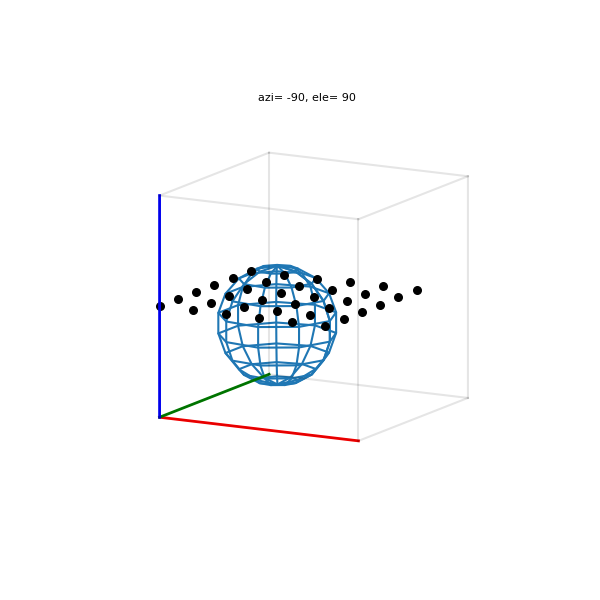

In [286]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot('111', projection='3d')

# lattice vectors
v1 = list(zip([0.0,0.0,0.0], lattice[0]))
v2 = list(zip([0.0,0.0,0.0], lattice[1]))
v3 = list(zip([0.0,0.0,0.0], lattice[2]))
ax.plot3D(v1[0],v1[1],v1[2], 'r-', lw=2)
ax.plot3D(v2[0],v2[1],v2[2], 'g-', lw=2)
ax.plot3D(v3[0],v3[1],v3[2], 'b-', lw=2)

# positions
s = ax.scatter(positions[:,0], positions[:,1], positions[:,2], marker='o', s=30, c='k')
s.set_edgecolors = s.set_facecolors = lambda *args:None
            
# surface
u = np.linspace(0, 2 * np.pi, 10)
v = np.linspace(0, np.pi, 10)
x = 0 + 3.5 * np.outer(np.cos(u), np.sin(v))
y = 0 + 3.5 * np.outer(np.sin(u), np.sin(v))
z = 0 + 3.5 * np.outer(np.ones(np.size(u)), np.cos(v))
# s1 = ax.plot_surface(x, y, z,  rstride=5, cstride=5, color='k', linewidth=0, alpha=0.1, shade=1,antialiased=True)
s1 = ax.plot_wireframe(x+lmax/2, y+lmax/2, z+lmax/2)        

# draw cube 
lmax = max(max(lattice[0]),max(lattice[1]),max(lattice[2]))
from itertools import product, combinations
r = [0, lmax]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s, e), color='k', alpha=0.1)        
        
ax.set_aspect("equal")        
ax._axis3don = False # box off
ax.view_init(elev=90, azim=-90)
title('azi= -90, ele= 90', fontsize=8)

In [331]:
def get_coulomb(pfile,target,dmax,axin):
    subprocess.call(' feff_poscar2atoms.py p='+pfile+' t='+str(target)+' d='+str(dmax)+' ', shell=True)
    p0 = np.loadtxt('atoms.xyz', unpack=True, comments='#', usecols=(1,2,3), skiprows=2)
    positions = p0.T
    lattice = [[dmax,0,0],[0,dmax,0],[0,0,dmax]]

    # read labels  
    with open('atoms.xyz') as f:
        lines = f.readlines()
    labels = []    
    for i, line in enumerate(lines):
        n = lines[i].split()[0] 
        labels.append(n)    
    del labels[0:2]


    # convert labels to Zs
    import PT
    Zs = []
    for i in labels:
        Zs.append(PT.get_z(i))


    coulomb_matrix = np.zeros((51, 51))

    if len(Zs) > 51:
        asize = 51
    else: asize = len(Zs)

    for i in range(asize):
        for j in range(asize):
            p1 = positions[i]; Z1 = Zs[i]
            p2 = positions[j]; Z2 = Zs[j]
            d = (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2
            d = np.sqrt(d)
            if i == j:
                coulomb_matrix[i,j] = 0.5*(Z2**2.4)
            if i != j:
                coulomb_matrix[i,j] = Z1*Z2/d   

    axin.matshow(coulomb_matrix)
    
    return coulomb_matrix

<IPython.core.display.Javascript object>


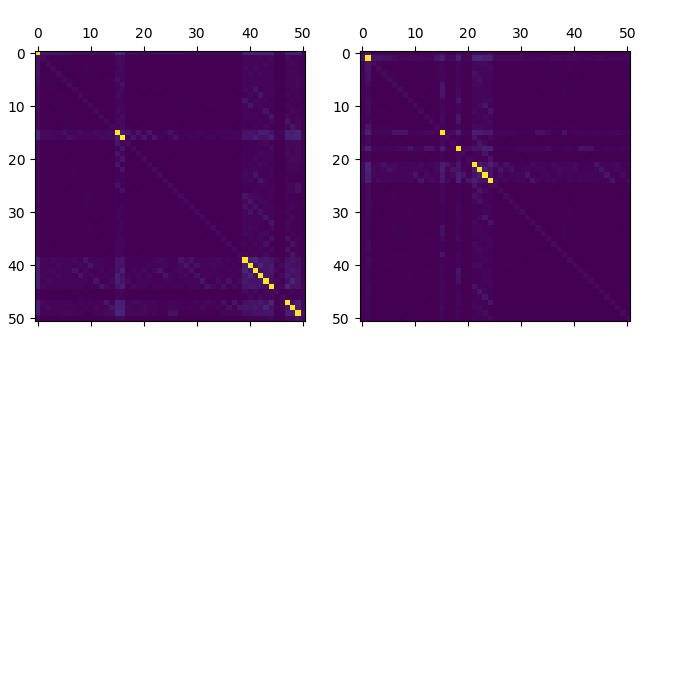

In [346]:
fig = plt.figure(figsize=(7,7))

gs = gridspec.GridSpec(2, 2, height_ratios=[1,1] )    
gs.update(top=0.93, bottom=0.07, left=0.05, right=0.9, wspace=0.2, hspace=0.2)


coulomb_matrix2 = get_coulomb(pfile='CONTCAR',target=1,dmax=9,axin=fig.add_subplot(gs[0]))
coulomb_matrix2 = get_coulomb(pfile='CONTCAR',target=5,dmax=9,axin=fig.add_subplot(gs[1]))